<h1 style="font-size:2em;color:#2467C0">Soccer Player Analysis</h1>


This program is used to analyze the data of 18,000+ soccer players from European Soccer leagues. The dataset used here is an open European Soccer Database downloaded from Kaggle. Rather than losing on focus on match details and league details, we restrict ourselves to details of individual players participating in these league matches. 


## Libraries Used

We have used following python libraries and we start by importing them first.
<ul>
<li>
<b>sqlite3</b> library is used to interact with the database throughout this program.
</li>
<li>
<b>pandas</b> for data ingestion 
</li>
<li>
<b>numpy</b> for data manipulation
</li>
<li>
<b>sklearn</b> methods for Machine Learning
</li>
<li>
<b>customplot</b> which contains custom functions which we have used in this notebook
</li>
<li>
<b>matplotlib</b> for data visualization
</li>

In [120]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from customplot import *

## Database connect
Once we have imported the desired libraries, we first connect to the downloaded database. After establishing the connection with database, we can ingest data using from the *Player_Attributes* relation from the given database. The ingested data is converted to the form of DataFrame using pandas.

In [121]:
conn = sqlite3.connect('database.sqlite')
df = pd.read_sql_query('select * from Player_Attributes',conn)

## Exploring and Cleaning the DataFrame
To have a clear view of what the DataFrame contains, we display the columns of the data frame which describes various player attributes such as acceleration, ball control, speed, agility, sprint speed, heading accuracy and so on. Once we have the clear understanding of the dataframe we need to eliminate the empty rows before we proceed forward with manipulation as the empty rows would effect the computations.

In [124]:
#This displays the set of all columns of given dataframe.
print(50*"_")
print ('\nVarious attributes of a player:')
print(50*"_")
for i in df.columns:
    print (i)


#This function is used to display the different statistcal computations of the data frame.
print()
print(90*"_")
print('\nStatistical values of the dataframe:')
print(90*"_")
print (df.describe().transpose())

#The dropna() method of pandas is used drop down all empty rows in the dataframe.
df = df.dropna()

__________________________________________________

Various attributes of a player:
__________________________________________________
id
player_fifa_api_id
player_api_id
date
overall_rating
potential
preferred_foot
attacking_work_rate
defensive_work_rate
crossing
finishing
heading_accuracy
short_passing
volleys
dribbling
curve
free_kick_accuracy
long_passing
ball_control
acceleration
sprint_speed
agility
reactions
balance
shot_power
jumping
stamina
strength
long_shots
aggression
interceptions
positioning
vision
penalties
marking
standing_tackle
sliding_tackle
gk_diving
gk_handling
gk_kicking
gk_positioning
gk_reflexes

__________________________________________________________________________________________

Statistical values of the dataframe:
__________________________________________________________________________________________
                       count           mean            std     min        25%  \
id                  180354.0   91995.886274   53092.657914     1.0   46

## Correlation Analysis of the features

The <b>*Overall Rating*</b> of the player is the most significant attribute to look for in a player. This *overall_rating* maybe dependent on number of other attributes and it is actually an average of all other weighted attributes of a player. We compute <b>correlation</b> that each attribute bears with *overall_rating*. We make use of correlation method in pandas to compute the <b>Pearson's Correlation coefficient</b>.


### Peasron's Correlation Coefficient

The Pearson's Correlation coefficient ranges from -1 to 1. A correlation of <b>-1</b> indicates that the attributes are inversely related to each other. A correlation of <b>0</b> indicates that no relation exist between the attributes. If correlation is nearer to positive side of 0, then there exists a weak correlation between the attributes, and closer to 1 indicates the presence of strong correlation. A correlation coefficient of <b>1</b> indicates perfect correlation between the attributes.

For our analysis, we only consider the attributes which are either weakly or strongly correlated to the *overall_rating* of the player. Attributes with negative correlation coefficient or correlation coefficient closer to 0 are neglected to focus only on the prime factors which decide the *overall_rating* of the player.

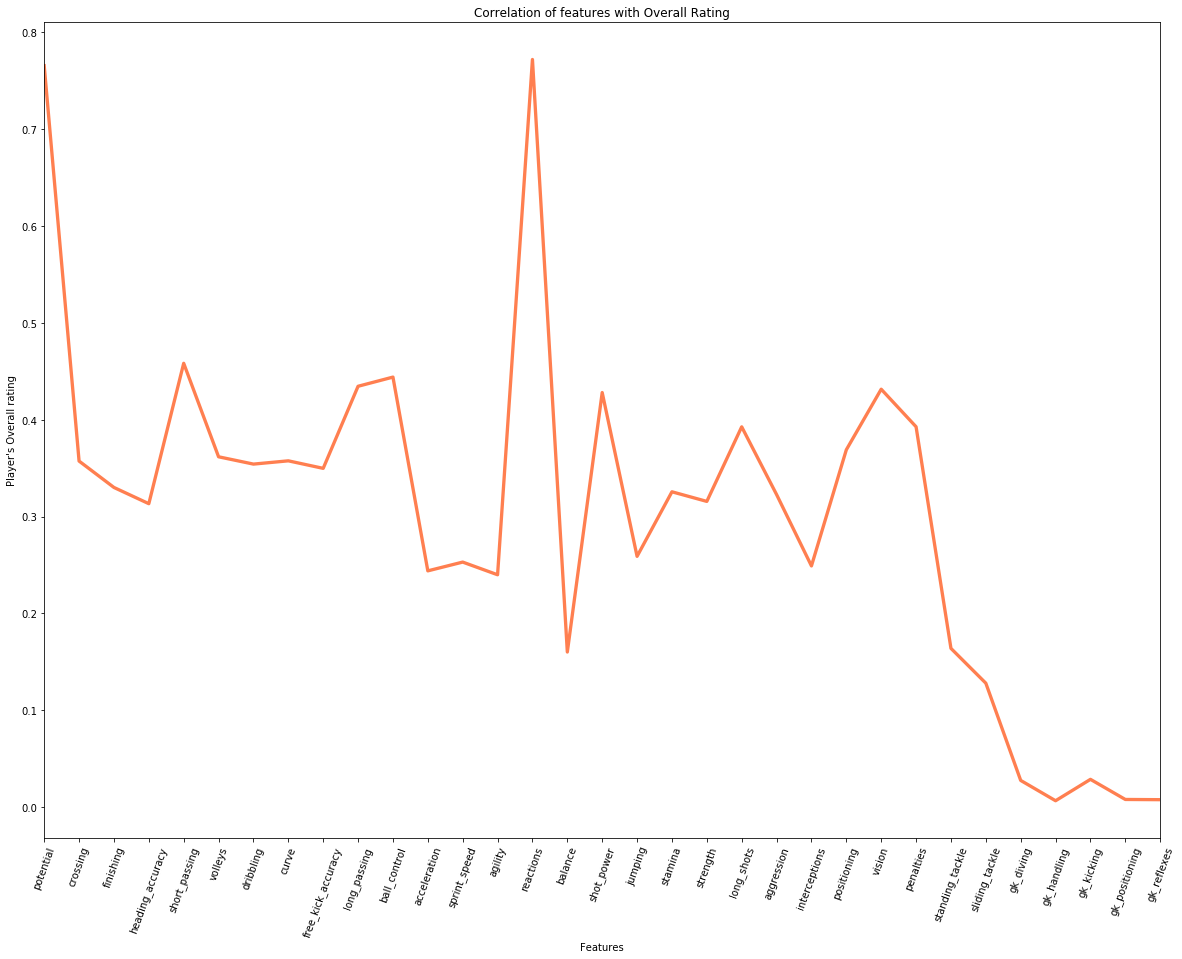

In [125]:
#Shuffling the rows of the dataframe so we get a new sample of rows at the top when we display the dataset.
df = df.reindex(np.random.permutation(df.index))

#Following attributes of the players are considered to be either weakly or 
features = ['potential', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 
            'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
            'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 
            'positioning', 'vision', 'penalties', 'standing_tackle', 'sliding_tackle',
            'gk_diving', 'gk_handling','gk_kicking', 'gk_positioning', 'gk_reflexes']
    
#computing the correlation of each attribute with overall_rating
correlations = [ df['overall_rating'].corr(df[f]) for f in features ]


#function to plot graph of correlation of attributed with overall_rating of the player.
def plot_correlation(df,x_label,y_label):
    fig = plt.gcf()
    fig.set_size_inches(20,15)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    ax = df.correlation.plot(linewidth=3.3,color = 'coral')
    ax.set_xticks(df.index)
    ax.set_xticklabels(df.attributes,rotation=70)
    plt.title('Correlation of features with Overall Rating')
    plt.show()
    
df2 = pd.DataFrame({'attributes' : features, 'correlation' : correlations })
plot_correlation(df2,'Features','Player\'s Overall rating')

### Analysis from graph
The peaks in the graph show that those attributes are <b>strongly correlated</b> with the *overall_rating* of the player. Hence, the following attributes should be considered while rating any player:
<ul>
<li>
*potential*
</li>
<li>
*reactions*
</li>
<li>
*short_passing*
</li>
<li>
*ball_control*
</li>
<li>
*vison*
</li>

## Clustering Players

In general, a football team typically consists of 11 players. Apart from the goalkeeper, there are 10 other players   who are spread across the field according to the team's formation. The 10 players fall into either of the four   categories:
<ul>
<li>
<b>Defenders</b>
</li>
<li>
<b>Midfielders</b>
</li>
<li>
<b>Wing Attackers</b>
</li>
<li>
<b>Center Forwards</b>
</li>

Players falling into each of this four categories have unique attributes which makes them to standout in their particular category. For instance, the defenders are supposed to have strong <b>interception</b> capablities to intrude into opposition's attack, while midfielders cover the most part of ground which is squarely attributed to their <b>potential</b>. Basically the attackers are further classified into wing attackers and center forwards. As their name suggests wing attackers and center forwards should have good <b>reaction</b> and <b>ball control</b> capablilites to embrace their positions in the team respectively. So, we cluster players based on these five attributes:<br>
1. <b>Diving</b>(Goal keeper)<br>
2. <b>Interceptions</b><br>
3. <b>Potential</b><br>
4. <b>Reaction</b><br>
5. <b>Ball control</b><br>

In [127]:
#Potential features of the players in each group
groupFeatures= ['gk_diving','interceptions', 'potential',  'reactions', 'ball_control']

print(50*"_")
print ("\nCorrelation Analysis of these grouping features:")
print(50*"_")
for f in groupFeatures:
    related = df['overall_rating'].corr(df[f])
    print ("%s : %.2f" % (f,related))

__________________________________________________

Correlation Analysis of these grouping features:
__________________________________________________
gk_diving : 0.03
interceptions : 0.25
potential : 0.77
reactions : 0.77
ball_control : 0.44


In [128]:
#Generating a new dataframe from the features which are defined as group features
df_select = df[groupFeatures].copy(deep=True)

print(90*"_")
print ("\nNew DataFrame :")
print(90*"_")
print (df_select)

#Perform scaling on the dataframe containing the features
groups = scale(df_select)

__________________________________________________________________________________________

New DataFrame :
__________________________________________________________________________________________
        gk_diving  interceptions  potential  reactions  ball_control
113828        9.0           74.0       70.0       66.0          42.0
183887        6.0           35.0       82.0       69.0          84.0
149154        6.0           25.0       81.0       66.0          64.0
152167       14.0           75.0       74.0       74.0          77.0
168721        7.0           47.0       72.0       54.0          56.0
135557        7.0           65.0       67.0       46.0          53.0
54376         8.0           56.0       66.0       50.0          32.0
88447         7.0           65.0       78.0       64.0          65.0
103823        8.0           65.0       64.0       68.0          60.0
125033        8.0           19.0       70.0       67.0          65.0
18535        14.0           38.0       77.

## Perform KMeans Clustering

We make use of maching learning method call KMeans() from sklearn module to perform the <b>KMeans Clustering</b> which aids grouping players based on the potential features (*namely gk_diving, interceptions, potential, reactions and ball control*). We will set the number of clusters to 5 as we are interested in only these five groups of players.

In [129]:
#Define number of clusters
clusters = 5

#Train a model using KMeans() machine learning method
model = KMeans(init='k-means++',n_clusters=clusters,n_init=20).fit(groups)

In [133]:
#Counting the number of players in each cluster
print(60*"_")
print("\nCount of players in each cluster : ")
print(60*"_")
pd.value_counts(model.labels_,sort=False)

____________________________________________________________

Count of players in each cluster : 
____________________________________________________________


0    33470
1    39277
2    14544
3    54637
4    38426
dtype: int64

In [134]:
#Create a compostite dataframe for plotting the newly formed dataframe
#Using custom function from customplot module which we import at the beginning of the program
df3 = pd_centers(featuresUsed = groupFeatures, centers = model.cluster_centers_)

print(90*"_")
print ("\nComposite DataFrame :")
print(90*"_")
print (df3)

__________________________________________________________________________________________

Composite DataFrame :
__________________________________________________________________________________________
   gk_diving  interceptions  potential  reactions  ball_control  prediction
0  -0.292521      -0.400013  -1.102226  -1.226892     -0.421687           0
1  -0.278619      -1.012430   0.423088   0.364580      0.626518           1
2   3.280860      -1.301324  -0.135386  -0.353798     -2.589791           2
3  -0.288792       0.632651  -0.309474  -0.094325      0.000995           3
4  -0.291571       0.974898   1.018100   0.963186      0.705412           4


## Visualization of Clusters


C:\Users\dell\customplot.py:31: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.
  parallel_coordinates(data, 'prediction', color = my_colors, marker='o')


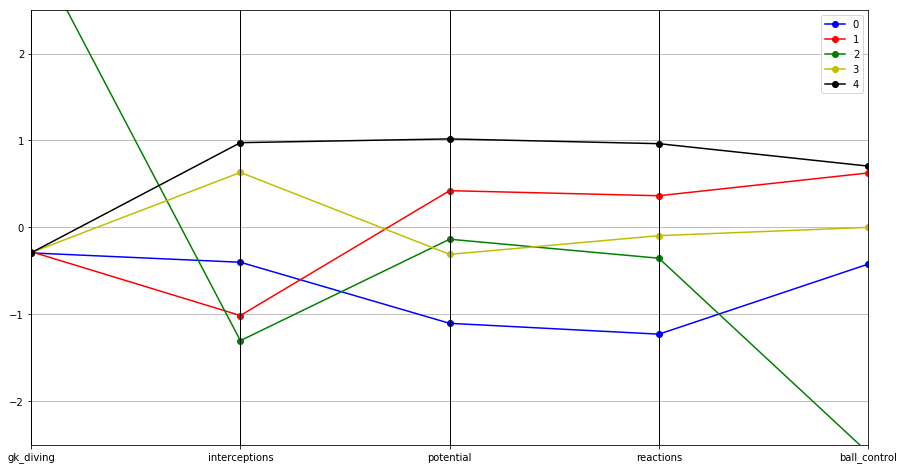

In [138]:
# For plotting graph inside notebook we use matplotlib inline
%matplotlib inline

#Plotting the five groups of players in the same graph to analyse what features they share in common with each other
parallel_plot(df3)

<h1 style="font-size:2em;color:#2467C0">Analysis of Findings</h1>
<ul>
<li>Two groups (*red and black*) are similar to each other except for interceptions capablities- these groups can coach each other in interceptions and where they differ.</li>
<li>
Two groups (*green and yellow*) seem to be equally talented in potential and reactions. These groups can coach each other in ball control, interceptions and gk_diving.
</li>
